In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
data = pd.read_csv("../input/digit-recognizer/train.csv")
X_test = pd.read_csv("../input/digit-recognizer/test.csv")
print(data.shape)

(42000, 785)


In [4]:
Y = data.iloc[:,0]
X = data.iloc[:,1:]
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,stratify = Y,random_state=0)
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
Y_train = np.asarray(Y_train)
Y_val = np.asarray(Y_val)
X_test = np.asarray(X_test)

X_train=np.reshape(X_train,(31500,1,28,28))
X_val=np.reshape(X_val,(10500,1,28,28))
X_test=np.reshape(X_test,(28000,1,28,28))
X_train.shape

(31500, 1, 28, 28)

In [5]:
X_train.shape[0]

31500

# CNN

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
X_train, Y_train, X_val, Y_val, X_test = map(torch.tensor,(X_train,Y_train,X_val,Y_val,X_test))

In [8]:
X_train.shape[0]

31500

In [9]:
class FirstNetwork_v2(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    
    
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)
        
        
    self.cnn = nn.Sequential(
        nn.Conv2d(1,6,5), # 1,28,28  6,24,24
        nn.Tanh(),
        nn.AvgPool2d(2, stride=2), #5, 24,24  5,12,12
        nn.Tanh(),
        nn.Conv2d(6,16,5),# 5,12,12  16,8,8
        nn.Tanh(),
        nn.AvgPool2d(2, stride=2) #16,8,8 16,4,4
    )
    self.fnn = nn.Sequential(
        nn.Linear(256, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10),
        nn.Softmax()
    )
    #self.fnn.apply(init_weights)

  def forward(self, X):
    X = self.cnn(X)
    X = X.view(X.size(0), -1)
    return self.fnn(X)

In [10]:
def fit_v2(x, y, model, opt, loss_fn, epochs = 50):
    
  loss_arr = {}
    
  for epoch in range(epochs):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss_arr[epoch] = loss

    loss.backward()
    opt.step()
    opt.zero_grad()
    print(str(epoch+1)+'/'+str(epochs))
    
  plt.plot(loss_arr.values())
  plt.xlabel('epoch')
  plt.ylabel('log loss')
  plt.show()
  return loss.item()

In [11]:
def predict(x, model):
    
    outputs = model(x)
    _,y_pred = torch.max(outputs.data, 1)
    return y_pred

def accuracy(x, y, model):
   
    correct = 0
    y_pred = predict(x, model)
    correct += (y_pred==y).sum().item()
    
    print('accuracy = ',correct/x.shape[0])

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50


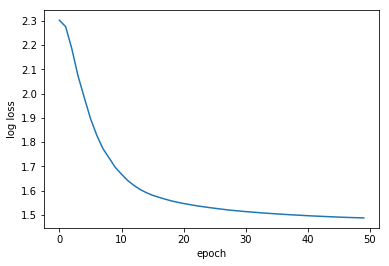

accuracy =  0.978
accuracy =  0.9672380952380952


In [12]:
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.Adam(fn.parameters(),lr = 0.0095,betas=(0.9,0.99), weight_decay=1e-5)
fit_v2(X_train.float(), Y_train, fn, opt, loss_fn)
accuracy(X_train.float(),Y_train,fn)
accuracy(X_val.float(),Y_val,fn)

In [13]:
Y_pred = predict(X_test.float(), fn)

submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submission["Label"] = Y_pred
submission = submission[['ImageId', 'Label']]
submission.to_csv("submisision.csv", index=False)